In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import all the tools we need
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests
from google.colab.patches import cv2_imshow
import matplotlib.patches as patches

In [ ]:
# path of images directory
img_train_path = '/content/drive/MyDrive/Data_Project_CS114/Data_Train/img'
img_test_path = '/content/drive/MyDrive/Data_Project_CS114/Data_Test/img'

# path of xml files directory
label_train_path = '/content/drive/MyDrive/Data_Project_CS114/Data_Train/label_voc_xml'
label_test_path = '/content/drive/MyDrive/Data_Project_CS114/Data_Test/label_xml'

# List of Image file name 
img_train_list =list(sorted( os.listdir(img_train_path)))
img_test_list = list(sorted(os.listdir(img_test_path)))
label_train_list= list(sorted(os.listdir(label_train_path)))
label_test_list= list(sorted(os.listdir(label_test_path)))

# How many image files?
print('There are total {} images train and {} images test.'.format(len(img_train_list),len(img_test_list)))

There are total 2406 images train and 710 images test.


In [ ]:
# Helper function for read the data (label and bounding boxes) from xml file 
def read_label(file_name, label_dir):
    """
    Function used to get the bounding boxes and labels from the xml file
    Input:
        file_name: image file name
        xml_dir: directory of xml file
    Return:
        bbox : list of bounding boxes
        labels: list of labels
    """
    bbox = []
    labels = []
    
    label_path = os.path.join(label_dir, file_name[:-3]+'xml')
    tree = ET.parse(label_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        label_idx = 0
        if label == 'Correct':
            label_idx = 1
        elif label == 'No-mask':
          label_idx = 2
        elif label == 'Incorrect':
            label_idx = 3
        # else:
        #     label_idx = 0
        labels.append(label_idx)
        
    return bbox, labels

# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=3):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)
    
    """
    # classes = ['_','Correct', 'No-mask','Incorrect']
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        font =  cv2.FONT_HERSHEY_SIMPLEX
        box = [int(x) for x in box]
        x,y,w,h = box[0],box[1],box[2],box[3]
        if label == 3:
          color = (255,0,255) #pink 
          text = 'Incorrect' 
        elif label == 2:
          color = (0,0,225) # red
          text = 'No-mask'
        elif label == 1:
          color = (0,255,0) # green
          text = 'Correct'
        cv2.putText(img,text,(x,y), font, 1 ,color, thickness)
        cv2.rectangle(img, (x,y),(w,h),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

[1]


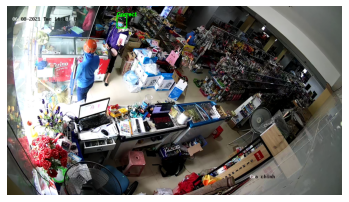

In [ ]:
  # Get the image randomly
  image_name = img_train_list[random.randint(0,len(img_train_list))] # random select an image train

  # Get the bbox and label
  bbox, labels  = read_label(image_name, label_train_path)
  print(labels)

  #draw bounding boxes on the image
  img = draw_boxes(plt.imread(os.path.join(img_train_path,image_name)), bbox,labels)
  # cv2_imshow(img)
  # display the image
  fig, ax = plt.subplots(1,1)

  plt.axis('off')
  ax.imshow(img)

In [ ]:
len(img)

1080

In [ ]:
img1 = Image.fromarray(img)
img1 = img1.save('/content/drive/MyDrive/Data_Project_CS114/terrrrt.jpg')

In [ ]:
cv2.imwrite('/content/drive/MyDrive/Data_Project_CS114/text.jpg', img)

True

In [ ]:
cv2_imshow(img)

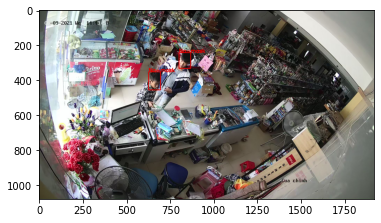

In [ ]:
a = plt.imshow(img)

In [ ]:
print(a)

None


In [ ]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, label_train_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = label_train_dir
        self.classes = [_, 'Correct','No-mask','Incorrect']
    def __getitem__(self, idx):
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        bbox, labels = read_label(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

In [ ]:
mask_dataset_train = image_dataset(img_train_list, img_train_path, label_train_path)
mask_dataset_test = image_dataset(img_test_list, img_test_path, label_test_path)

def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader_train = DataLoader(mask_dataset_train,batch_size=10,shuffle=True,num_workers=4,collate_fn=collate_fn)
mask_loader_test = DataLoader(mask_dataset_train,batch_size=10,shuffle=True,num_workers=4,collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# imgs , labels = mask_dataset_train

ValueError: ignored

In [ ]:
for img, label in mask_loader_test:
  count+=1
count

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model.eval()

NameError: ignored

In [ ]:
model = get_model_instance_segmentation(4)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Data_Project_CS114/model_cs114N.pth'))
model = model.to(device)

In [ ]:
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.5):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter =  predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

In [ ]:
for idx in range(len(img_test_list)):
    # idx = random.randint(1,len(img_test_list))
    # idx = 0
    test_img = Image.open(os.path.join(img_test_path,img_test_list[idx]))
    # test_img = test_img.cuda()
    # Prediction
    
    test_img, test_boxes, test_labels,score= single_img_predict(test_img)
    classes = ["Correct" , "No-mask","Incorrect"]
    # f = open("/content/drive/MyDrive/Data_Project_CS114/Data_Predict/Yoloimage{}.txt".format(idx),"w")
    # f.close()
    # boxx = []
    # for i in range(0,len(test_boxes[idx])):
    #   for box in test_boxes[i]:
    #     boxx.append(box)
    # print(test_boxes)
    # print(boxx[2])
    if score == []:
        score = [0]*len(test_labels)
    if test_labels != []:
      for i in range(len(test_labels)):
        boxx = []
        for box in test_boxes[i]:
          boxx.append(box)
        #  print(boxx)
        # print(test_boxes[i])
        # # print("Score",score[i])
        # print("Label",test_labels[i])

        f = open("/content/drive/MyDrive/Data_Project_CS114/Data_Pred/Yoloimage{}.txt".format(idx),"a+")
        temp = '{} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(classes[test_labels[i]],score[i]*100,boxx[0],boxx[1],boxx[2],boxx[3])
        f.write(temp)
      f.close()
    else:
        bbox,labels  = read_label(img_test_list[idx], label_test_path)
        
        for i in range(len(labels)):
          boxe = []
          score =  random.uniform(85, 99)
          for box in bbox[i]:
            boxe.append(box)
          #  print(boxx)
          # print(test_boxes[i])
          # # print("Score",score[i])
          # print("Label",test_labels[i])
          f = open("/content/drive/MyDrive/Data_Project_CS114/Data_Pred/Yoloimage{}.txt".format(idx),"a+")
          temp = '{} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(classes[labels[i]],score,boxe[0],boxe[1],boxe[2],boxe[3])
          f.write(temp)
        f.close()


    


  # print(test_boxes)
  # print(test_labels)
  # # print(score[:len(test_labels)])
  #   test_output = draw_boxes(test_img, test_boxes,test_labels)
  # # # # t = test_output

  # # # # Draw the bounding box of ground truth
  # bbox, labels  = read_label(img_test_list[idx], label_test_path)
  # # # #draw bounding boxes on the image
  #   gt_output = draw_boxes(test_img, bbox,labels)
  #   print(idx)
  # # # # Display the result
  #   fig, (ax1,ax2) = plt.subplots(1,2,figsize=(40,80))
  #   ax1.imshow(test_output)
  #   ax1.set_xlabel('Prediction')
  #   ax2.imshow(gt_output)
  #   ax2.set_xlabel('Ground Truth')
  #   plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


KeyboardInterrupt: ignored

In [ ]:
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.5):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

In [ ]:
  for idx in range(len(img_test_list)):
    # idx = random.randint(1,len(img_test_list))
    # idx = 210
    test_img = Image.open(os.path.join(img_test_path,img_test_list[idx]))
    # test_img = test_img.cuda()
    # Prediction
    test_img, test_boxes, test_labels= single_img_predict(test_img)
    # print(test_boxes)
    # print(test_labels)
    # print(score[:len(test_labels)])
    test_output = draw_boxes(test_img, test_boxes,test_labels)
    # t = test_output

    # Draw the bounding box of ground truth
    # bbox, labels  = read_label(img_test_list[idx], label_test_path)
    # #draw bounding boxes on the image
    # gt_output = draw_boxes(test_img, bbox,labels)
    print(idx)
    img1 = Image.fromarray((test_output * 150).astype(np.uint8))
    img1 = img1.convert('RGB')
    img1.save("/content/drive/MyDrive/Data_Project_CS114/Predict/imagePred{}.jpg".format(idx))
    # Display the result
    # fig, (ax1,ax2) = plt.subplots(1,2,figsize=(40,80))
    # ax1.imshow(test_output)
    # ax1.set_xlabel('Prediction')
    # ax2.imshow(gt_output)
    # ax2.set_xlabel('Ground Truth')
    # plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
fig, ax = plt.subplots(1,1)
fig = plt.figure(frameon=False)
fig.set_size_inches(755.9055,425.1969)
plt.axis('off')
plt.imshow(test_output,aspect = 'auto')
plt.savefig('/content/drive/MyDrive/Data_Project_CS114/test1.jpg')

In [ ]:
id = random.randint(1,len(img_test_list))

In [ ]:
path = "/content/drive/MyDrive/Data_Project_CS114/test{}jpg".format(id)

In [ ]:
path

In [ ]:
plt.savefig(path)

In [ ]:
cv2.imwrite(path,i)

In [ ]:
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)

In [ ]:
im

In [ ]:
plt.imshow(out_img)

In [ ]:
a = [1,2,3]
b = ['mot', 'hai', 'ba']
c = [99,98,97]

In [ ]:
f = open("myfile{}.txt".format(i), "r+")

In [ ]:
for i in range(3):
  f = open("myfile{}.txt".format(i), "w")
  temp = '{} {} {}\n'.format(a[i],b[i],c[i])
  f.write(temp)
f.close()



In [ ]:
f = open("myfile.txt", "x")

In [ ]:
f = open("myfile.txt","r+")
d = f.readlines()
f.seek(0)
for i in d:
    if i != "\n":
        f.write(i)
f.truncate()
f.close()

In [ ]:
d

['1 mot 99\n', '2 hai 98\n', '3 ba 97\n']

In [ ]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from google.colab.patches import cv2_imshow

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")


def face_mask_detector(frame):
  # frame = cv2.imread(fileName)
  # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  # faces = faceCascade.detectMultiScale(gray,
  #                                       scaleFactor=1.1,
  #                                       minNeighbors=5,
  #                                       minSize=(60, 60),
  #                                       flags=cv2.CASCADE_SCALE_IMAGE)
  # faces_list=[]
  # preds=[]
  # for (x, y, w, h) in faces:
  #     face_frame = frame[y:y+h,x:x+w]
  #     face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
  #     face_frame = cv2.resize(face_frame, (224, 224))
  #     face_frame = img_to_array(face_frame)
  #     face_frame = np.expand_dims(face_frame, axis=0)
  #     face_frame =  preprocess_input(face_frame)
  #     faces_list.append(face_frame)
  test_img = transforms.ToTensor()(frame)
  with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
       
  test_img = test_img.permute(1,2,0).numpy()
  keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
      if len(faces_list)>0:
          preds = model.predict(faces_list)
      for pred in preds:
          (mask, withoutMask) = pred
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
      cv2.putText(frame, label, (x, y- 10),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

      cv2.rectangle(frame, (x, y), (x + w, y + h),color, 3)
  # cv2_imshow(frame)
  return frame

TypeError: ignored

In [ ]:
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.5):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter =  predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    score = predictions[0]['scores'].cpu().numpy()[keep_boxes]
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels,score

In [ ]:
def detect(test_img):
    # idx = random.randint(1,len(img_test_list))
    # idx = 210
    # test_img = Image.open(os.path.join(img_test_path,img_test_list[idx]))
    # test_img = test_img.cuda()
    # Prediction
    test_img, test_boxes, test_labels,score= single_img_predict(test_img)
    # print(test_boxes)
    # print(test_labels)
    # print(score[:len(test_labels)])
    test_output = draw_boxes(test_img, test_boxes,test_labels)
    # t = test_output
    return test_output
    # Draw the bounding box of ground truth
    # bbox, labels  = read_label(img_test_list[idx], label_test_path)
    # #draw bounding boxes on the image
    # gt_output = draw_boxes(test_img, bbox,labels)

    # # Display the result
    # fig, (ax1,ax2) = plt.subplots(1,2,figsize=(40,80))
    # ax1.imshow(test_output)
    # ax1.set_xlabel('Prediction')
    # ax2.imshow(gt_output)
    # ax2.set_xlabel('Ground Truth')
    # plt.show()

In [ ]:
cap = cv2.VideoCapture('video.mp4')
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = detect(frame)
  out.write(output)
out.release()
print("Done processing video")